In [85]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#Fixing the tweets
import string

# Model Imports
# Using the Bidirectional LSTM concept as discussed in my paper

from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Flatten, Dropout, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# It looks like online resources promote NLTK tools for the 
# https://stackoverflow.com/questions/19560498/faster-way-to-remove-stop-words-in-python Andy Rimmer
from nltk.corpus import stopwords
cachedStopWords = stopwords.words('english')

In [86]:
sentiment_df = pd.read_csv("covid-19_vaccine_tweets_with_sentiment.csv", encoding='iso-8859-1')
display(sentiment_df.head(5))
display(sentiment_df['tweet_text'].values[0])
#Notice there is a lot of bad symbols in the data for training that we will need to get rid of

,tweet_id,label,tweet_text
0,1.360342e+18,1,"4,000 a day dying from the so called Covid-19 ..."
1,1.382896e+18,2,Pranam message for today manifested in Dhyan b...
2,1.375673e+18,2,Hyderabad-based ?@BharatBiotech? has sought fu...
3,1.381311e+18,1,"Confirmation that Chinese #vaccines ""dont hav..."
4,1.362166e+18,3,"Lab studies suggest #Pfizer, #Moderna vaccines..."


'4,000 a day dying from the so called Covid-19 \x93vaccine\x94 @DailyBeast reports. #vaccine #PfizerVaccine #Moderna \n\nhttps://t.co/p1nQWWZpk4'

In [87]:
# Exploring the shape and info of our data
display(sentiment_df.shape)
display(sentiment_df.info())


(6000, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tweet_id    6000 non-null   float64
 1   label       6000 non-null   int64  
 2   tweet_text  6000 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 140.8+ KB


None

## Dataset with labels is read in but unbalanced

label
1     420
2    3680
3    1900
Name: count, dtype: int64

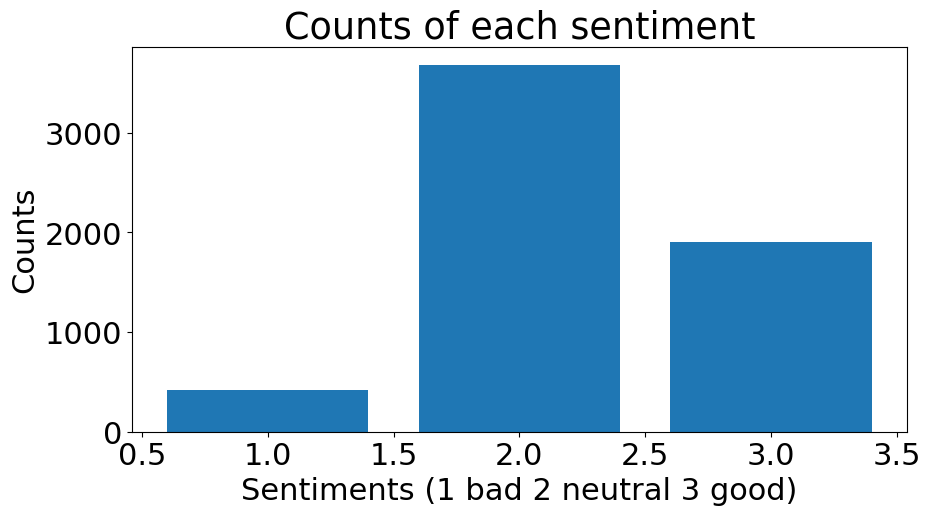

(6000, 3)

In [88]:
# Observing the counts of each sentiment in the data. So far it is skewed towards a neutral sentiment
counts = sentiment_df['label'].value_counts().sort_index()
display(counts)
plt.figure(figsize=(10,5))
plt.bar(counts.index, counts.values)
plt.xlabel('Sentiments (1 bad 2 neutral 3 good)')
plt.ylabel('Counts')
plt.title('Counts of each sentiment')
plt.show()
sentiment_df.shape

# Balance the training dataset using suplemental dataset.
## Used tags that were non political for bosting counts of negative sentiment, this was done to avoid introducing my own bias

In [89]:
covid_df = pd.read_csv('covidvaccine.csv')
covid_df.dropna(inplace=True)
covid_df = covid_df[covid_df['text'].str.contains('NoVax|CovidIsHoax|Mistrust|Setbacks|LongTermEffects|didn\'t work|migraine|headache|chills|aches|isn\t safe')]
newNeg = covid_df[['text']].copy()

newNeg['tweet_id'] = np.random.randint(100000,999999, size=len(newNeg))
newNeg['label'] = 1
newNeg = newNeg.rename(columns={'text': 'tweet_text'})
newNeg['tweet_text'][:10].values


sentiment_df = pd.concat([sentiment_df, newNeg], ignore_index=True)
sentiment_df.shape

C:\Users\arick\AppData\Local\Temp\ipykernel_26536\3745994604.py:1: DtypeWarning: Columns (5,6,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  covid_df = pd.read_csv('covidvaccine.csv')


(7261, 3)

label
1    1681
2    3680
3    1900
Name: count, dtype: int64

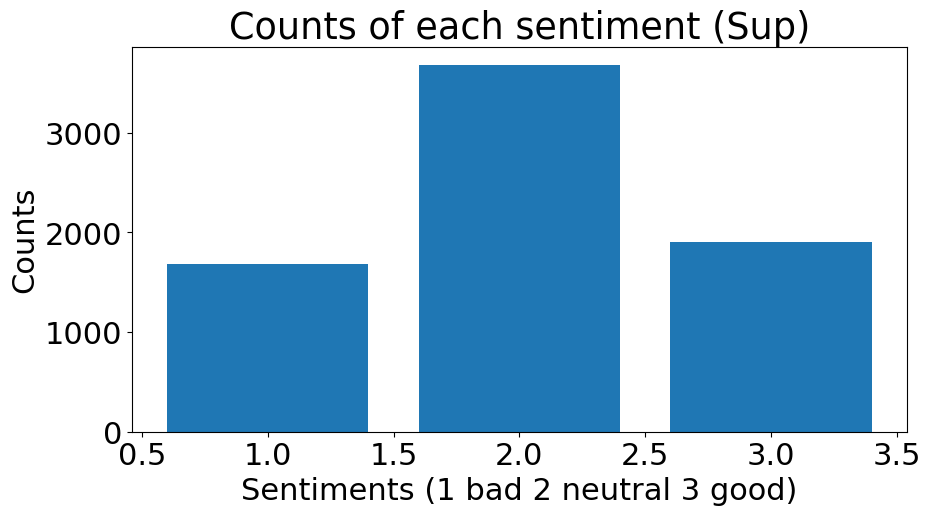

In [90]:
# Observing the counts of each sentiment in the data. So far it is skewed towards a neutral sentiment
counts = sentiment_df['label'].value_counts().sort_index()
display(counts)
plt.figure(figsize=(10,5))
plt.bar(counts.index, counts.values)
plt.xlabel('Sentiments (1 bad 2 neutral 3 good)')
plt.ylabel('Counts')
plt.title('Counts of each sentiment (Sup)')
plt.show()

## Clean data of all unwanted symbols like html links and emojis

In [91]:
#Perhops inefficeint data cleaning...
def removepunc(sentence):
    #Removing the unwanted characters in the dumbest way
    ridUnk = sentence.replace('\n', ' ').replace('\r', ' ')
    #Trans made with help from chat GPT
    trans = str.maketrans('','',string.punctuation)
    transed = ridUnk.translate(trans)
    #using NLTK to remove the stopwords that are common and useless
    #https://stackoverflow.com/questions/19560498/faster-way-to-remove-stop-words-in-python Andy Rimmer
    cleaned = ' '.join([word for word in transed.split() if word not in cachedStopWords])
    return cleaned

def removelinks(sentence):
    if 'http' in sentence:
        new_sent = " ".join([word for word in sentence.split() if not word.startswith('http')])
        sentence = new_sent
    return sentence

In [92]:
sentiment_df["tweet_text"]=sentiment_df["tweet_text"].str.lower()
#Help with removing grammar https://stackoverflow.com/questions/39782418/remove-punctuations-in-pandas user Bob Haffner
sentiment_df["tweet_text"]= sentiment_df["tweet_text"].apply(lambda x: removepunc(x))
#Removing the new lines and return lines
sentiment_df["tweet_text"]=sentiment_df["tweet_text"].str.replace("[^a-zA-Z0-9\w\s]", '',regex=True)
sentiment_df["tweet_text"]=sentiment_df["tweet_text"].apply(lambda x: removelinks(x))


In [93]:
sentiment_df["tweet_text"][40:51].values

array(['researchers said risk cerebral venous thrombosis covid approximately 10 times higher compared messenger rna vaccines 8 times higher compared oxfordastrazeneca vaccine',
       'well decide first country send leftover uk oxfordastrazeneca vaccines good friends australia allies 5 eyes family ties',
       'got second moderna covid19 shot empty thursday opens everyone go getvaccinated covidvaccine covid19vaccination its everybodys turn',
       'guy got first dose moderna vaccine today halfway closer getting back lawrence moderna sleeveupjoco',
       'anticovid19 update india becomes 60th country authorise use sputnikvaccine india set produce 50 mln doses vaccine per month summer serbia starts sputnikv production staysafe stopcovid19',
       'lindainlight normanswan astrazenica substantially lower efficacy pfizer moderna blood clot deaths rare across age groups vaccinated including aged 55',
       'astrazeneca vaccine causing blood clots nonsense mother shot two weeks ago got h

## Prepare data for training

In [94]:
X = []
X = sentiment_df['tweet_text'].values

y = sentiment_df['label'].values

In [95]:
#using Tokenizers to make the dimentionality smaller for our given problem. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)


In [96]:
word_tokenizers = Tokenizer()

#Important to use this in the future for the unlabeled data set that I will be making 
word_tokenizers.fit_on_texts(X_train)


X_train = word_tokenizers.texts_to_sequences(X_train)
X_test = word_tokenizers.texts_to_sequences(X_test)

In [ ]:
X_train

In [98]:
total_len = len(word_tokenizers.word_index) + 1
total_len

17033

In [99]:
padding_size = 125

X_train = pad_sequences(X_train, padding='post', maxlen=padding_size)
X_test = pad_sequences(X_test, padding='post', maxlen=padding_size)


# Training of the biased model
Uncomment the machines that intrest you but none will be better than the Bidirectional LSTM
Overfitting is still a problem

In [100]:
# Thoretically could use glove to better the dimentionality but I don't have time...
'''
THe model that works for the biased machine testing If you want to test the machines that didn't do as well but are listed in the document then look at the commented out ones above.
'''
from keras.utils import to_categorical

# # Assuming y_train and y_test are your label arrays with values 0, 1, or 2
# y_train_encoded = to_categorical(y_train - 1, num_classes=3)
# y_test_encoded = to_categorical(y_test - 1, num_classes=3)


# Bidirectional RNN Model
# embedding_feats = 200
# snn_model = Sequential()
# embbeding_layer = Embedding(total_len, embedding_feats, input_length=padding_size)
# snn_model.add(embbeding_layer)
# snn_model.add(Bidirectional(SimpleRNN(50, activation='tanh', dropout=.2, recurrent_dropout=.2)))
# snn_model.add(Dense(10, activation='tanh'))
# snn_model.add(Dense(3, activation='softmax'))
# snn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(snn_model.summary())

# GRU Model
# y_train_encoded = to_categorical(y_train - 1, num_classes=3)
# y_test_encoded = to_categorical(y_test - 1, num_classes=3)

# embedding_feats = 200
# snn_model = Sequential()
# embbeding_layer = Embedding(total_len, embedding_feats, input_length=padding_size)
# snn_model.add(embbeding_layer)
# snn_model.add(GRU(50, activation='tanh', dropout=.2, recurrent_dropout=.2))
# snn_model.add(Dense(10, activation='tanh'))
# snn_model.add(Dense(3, activation='softmax'))
# snn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(snn_model.summary())

# LSTM Model
# y_train_encoded = to_categorical(y_train - 1, num_classes=3)
# y_test_encoded = to_categorical(y_test - 1, num_classes=3)

# embedding_feats = 200
# snn_model = Sequential()
# embbeding_layer = Embedding(total_len, embedding_feats, input_length=padding_size)
# snn_model.add(embbeding_layer)
# snn_model.add(LSTM(50, activation='tanh', dropout=.2, recurrent_dropout=.2))
# snn_model.add(Dense(10, activation='tanh'))
# snn_model.add(Dense(3, activation='softmax'))
# snn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(snn_model.summary())

# LSTM
y_train_encoded = to_categorical(y_train - 1, num_classes=3)
y_test_encoded = to_categorical(y_test - 1, num_classes=3)

embedding_feats = 200
snn_model = Sequential()
embbeding_layer = Embedding(total_len, embedding_feats, input_length=padding_size)
snn_model.add(embbeding_layer)
snn_model.add(Bidirectional(LSTM(50, activation='tanh', dropout=.2, recurrent_dropout=.2)))
snn_model.add(Dense(10, activation='tanh'))
snn_model.add(Dense(3, activation='softmax'))
snn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(snn_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 125, 200)          3406600   
                                                                 
 bidirectional_3 (Bidirecti  (None, 100)               100400    
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 10)                1010      
                                                                 
 dense_7 (Dense)             (None, 3)                 33        
                                                                 
Total params: 3508043 (13.38 MB)
Trainable params: 3508043 (13.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [101]:
basic_LSTM = snn_model.fit(X_train, y_train_encoded, batch_size=256, epochs=5, verbose=1, validation_split=.4)

Epoch 1/5
14/14 [==============================] - 25s 1s/step - loss: 0.6428 - accuracy: 0.3861 - val_loss: 0.5989 - val_accuracy: 0.5052
Epoch 2/5
14/14 [==============================] - 20s 1s/step - loss: 0.5792 - accuracy: 0.4977 - val_loss: 0.5576 - val_accuracy: 0.5164
Epoch 3/5
14/14 [==============================] - 20s 1s/step - loss: 0.5113 - accuracy: 0.6386 - val_loss: 0.5140 - val_accuracy: 0.6764
Epoch 4/5
14/14 [==============================] - 20s 1s/step - loss: 0.4315 - accuracy: 0.8077 - val_loss: 0.4620 - val_accuracy: 0.7229
Epoch 5/5
14/14 [==============================] - 20s 1s/step - loss: 0.3446 - accuracy: 0.8665 - val_loss: 0.4263 - val_accuracy: 0.7371


In [102]:
score = snn_model.evaluate(X_test, y_test_encoded, verbose=1)
score

46/46 [==============================] - 2s 34ms/step - loss: 0.4155 - accuracy: 0.7522


[0.4155026078224182, 0.7522367238998413]

In [103]:
print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")

Test Loss: 0.4155026078224182
Test Accuracy: 0.7522367238998413


In [104]:
predictions = snn_model.predict(X_test)
predictions = np.argmax(predictions, axis=1) + 1

46/46 [==============================] - 2s 34ms/step


# The Big Part! Tesing data will be below

## Begin exploring ord maps and data to find tags that I havent already encountered

['informed',
 'want',
 'joint',
 'long',
 'make',
 'reactions',
 '7',
 '100',
 'age',
 'youre',
 'pains',
 'teaches',
 'feeing',
 'acute',
 'sick',
 'help',
 'million',
 'hit',
 'less',
 'products',
 'etc',
 'russia',
 'went',
 'super',
 '5',
 'omicron',
 'reports',
 'sideeffects',
 'virus',
 'variant',
 'sleep',
 'children',
 'uk',
 'head',
 'death',
 'another',
 'animal',
 'happy',
 'sinus',
 'full',
 'quick',
 'coaches',
 'adverse',
 'immunity',
 'developed',
 'big',
 'countries',
 'away',
 'next',
 'think']

(-0.5, 399.5, 199.5, -0.5)

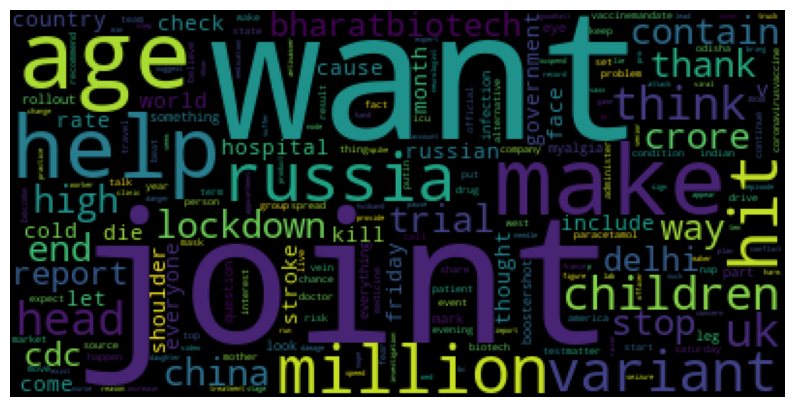

In [105]:
negative = sentiment_df[sentiment_df['label'] == 1]

# A good way of counting found here https://stackoverflow.com/questions/29903025/count-most-frequent-100-words-from-sentences-in-dataframe-pandas Joran Beasley
from collections import Counter

commonNeg = Counter(" ".join(negative['tweet_text']).split()).most_common()[200:]

noCountNeg = []
for x in commonNeg[:50]:
    noCountNeg.append(x[0])
display(noCountNeg)

plt.figure(figsize=(10,10))
wrd = WordCloud(stopwords=cachedStopWords)
wrd.generate("|".join([word for word, count in commonNeg]))
plt.imshow(wrd)
plt.axis('off')

['vaccine',
 'covid19',
 'moderna',
 'covaxin',
 'sputnikv',
 'pfizer',
 'vaccines',
 'pfizerbiontech',
 'first',
 'doses',
 'amp',
 'dose',
 'covidvaccine',
 'covid',
 'coronavirus',
 'astrazeneca',
 'vaccination',
 'sinopharm',
 'india',
 'get',
 'sinovac',
 'covishield',
 'russia',
 'shot',
 'today',
 'us',
 'people',
 'got',
 'health',
 'covid19vaccine']

(-0.5, 399.5, 199.5, -0.5)

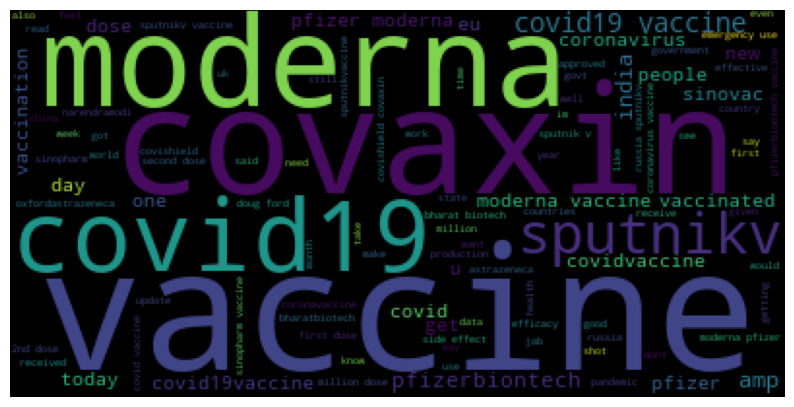

In [106]:
neut_sent = sentiment_df[sentiment_df['label'] == 2]

commonNeut = Counter(" ".join(neut_sent['tweet_text']).split()).most_common(30)

noCountNuet = []
for x in commonNeut:
    noCountNuet.append(x[0])
display(noCountNuet)


plt.figure(figsize=(10,10))
wrd = WordCloud(stopwords=cachedStopWords)
wrd.generate(" ".join(neut_sent.tweet_text))
plt.imshow(wrd)
plt.axis('off')

['healthcare',
 'lets',
 'volunteers',
 'ocgn',
 'normal',
 'via',
 'working',
 'appointment',
 'didnt',
 'russian',
 'real',
 'long',
 'double',
 'proud',
 'bit',
 'injection',
 'help',
 '10',
 'since',
 'fine',
 'stay',
 'excited',
 'eu',
 'staff',
 'neutralises',
 'post',
 'ago',
 'little',
 'parents',
 'works',
 'want',
 'developed',
 'center',
 'think',
 'update',
 'fight',
 'workers',
 'sputnikvaccine',
 'others',
 'headache',
 '12',
 'making',
 'trials',
 'chinese',
 'could',
 'super',
 'come',
 'read',
 'ill',
 'protection',
 'thats',
 '100',
 'multiple',
 'ocugen',
 'indias',
 '90',
 'thankful',
 'chinas',
 'ready',
 'possible',
 'administered',
 'love',
 'modernatx',
 'number',
 'potus',
 'fauciouchie',
 'severe',
 'modernavaccine',
 'know',
 'country',
 'able',
 'stop',
 'home',
 'months',
 'coronavirusvaccine',
 'appointments',
 'found',
 'pmoindia',
 'wearamask',
 'drive',
 'indian',
 'pm',
 'centre',
 '2021',
 'yes',
 'blood',
 'monday',
 'felt',
 'drug',
 'government',
 

(-0.5, 399.5, 199.5, -0.5)

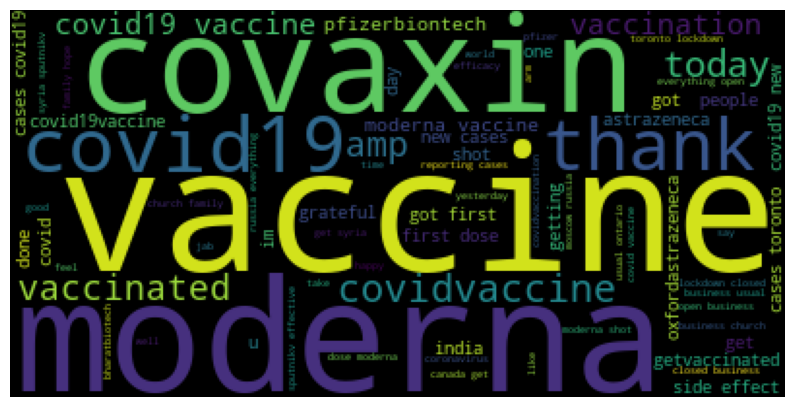

In [107]:
positive = sentiment_df[sentiment_df['label'] == 3]

commonPositive = Counter(" ".join(positive['tweet_text']).split()).most_common()[200:]

noCountPos = []
for x in commonPositive:
    noCountPos.append(x[0])
display(noCountPos)


plt.figure(figsize=(10,10))
wrd = WordCloud(stopwords=cachedStopWords)
wrd.generate(" ".join(positive.tweet_text))
plt.imshow(wrd)
plt.axis('off')

Political exploration

## Visualize on training dataset with true sentiment labels not predicted ones

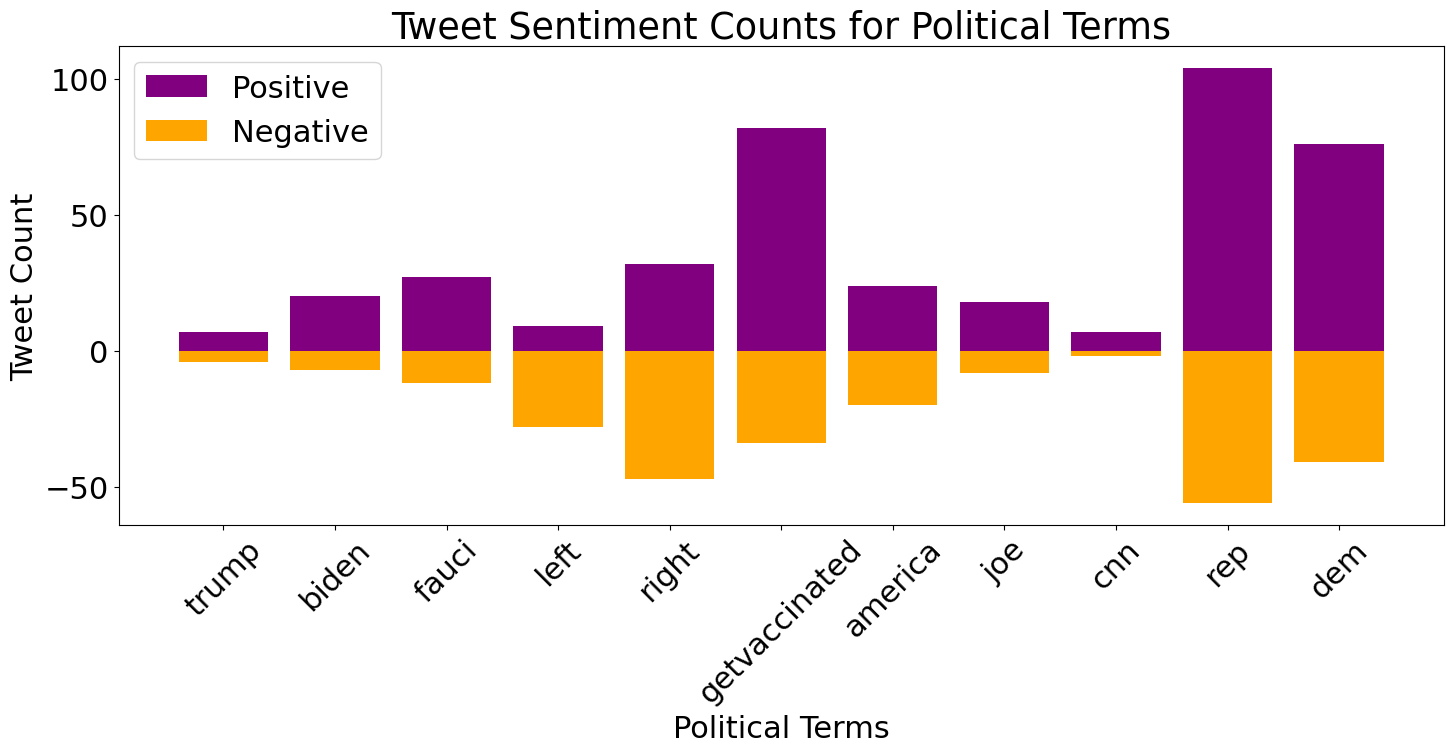

In [108]:
# politicalTerms = ['trump', 'conservative', 'maga', 'fakenews', 'GOP', 'biden', 'biden', 'harris', 'haris',
#          'fauci', 'democrat', 'left', 'vaccinessavelives', 'followthescience',
#          'getvaccinated', 'vaccineforall', 'covidiots', 'sidesffects', 'america', 'joe', 'kamila', 'foxnews',
#          'blm', 'karen', 'cnn', 'police', 'rep', 'dem', ]

"""This is for graphing inside of the final paper the above version is more comprehensive and interesting but 
doesn't appear on the paper well. Same goes for the other sections labeled the same way below. This is here just for standardization"""
politicalTerms= ['trump',  'biden', 
         'fauci', 'left', 'right', 'getvaccinated',
          'america', 'joe', 'cnn', 'rep', 'dem']

negativeTerms = []
positiveTerms = []

for pol in politicalTerms:
    tempFramePol = sentiment_df[sentiment_df['tweet_text'].str.contains(pol)]
    countPol = tempFramePol['tweet_text'].count()
    goodPol  = tempFramePol[tempFramePol['label'] == 3]
    countGPol = goodPol['tweet_text'].count()
    badPol  = tempFramePol[tempFramePol["label"] == 1]
    countBPol = badPol['tweet_text'].count() * -1
    
    negativeTerms.append(countBPol)
    positiveTerms.append(countGPol)

plt.figure(figsize=(15, 8))
plt.bar(politicalTerms, positiveTerms, color='purple', label='Positive')
plt.bar(politicalTerms, negativeTerms, color='orange', label='Negative')
plt.xlabel('Political Terms')
plt.ylabel('Tweet Count')
plt.title('Tweet Sentiment Counts for Political Terms')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.rcParams.update({'font.size': 22}) # From Mateen Ulhaq at https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot

# Introduction to live testing dataset

In [109]:
total_tweets = pd.read_csv('vaccination_all_tweets.csv')

politicalTerms = ['Trump', 'trump', 'Conservative', 'MAGA', 'FakeNews', 'GOP', 'biden', 'Biden', 'harris', 'haris',
         'Fauci', 'fauci', 'Democrat', 'democrat', 'Left', 'left', 'VaccinesSaveLives', 'FollowTheScience',
         'GetVaccinated', 'VaccineForAll', 'COVIDIOTS', 'SideEffects', 'America', 'Joe', 'Kamila', 'FoxNews',
         'BLM', 'Karen', 'CNN', 'Police', 'Rep', 'Dem', "Right", 'right', 'donald']

only_text= total_tweets[['text']].copy()
only_text = only_text[only_text['text'].str.contains('Trump|trump|Conservative|MAGA|FakeNews|GOP|biden|Biden|Harris|haris|Fauci|fauci|Democrat|democrat|Left|left|VaccinesSaveLives|FollowTheScience|GetVaccinated|VaccineForAll|COVIDIOTS|SideEffects|America|Joe|Kamila|FoxNews|BLM|Karen|CNN|Police|Rep|Dem|donald|america')]

only_text = only_text.rename(columns={'text': 'tweet_text'})
display(only_text['tweet_text'][20:30].values)
display(len(only_text))
#8000+ politically charged tweets to see how training on them changes the bias


array(['What kind of #America will he leave behind?\n-\n#Trump #DonaldTrump #JoeBiden #NewYork #Washington #WhiteHouse… https://t.co/kImRJ2Yjxs',
       '@chesleydohl @Audie_Murphy45 @cspan So why is Trump claiming the #PfizerBioNTech vaccine as one of his administrati… https://t.co/coClJkakMt',
       'What a great day for our Country &amp; the World! @realDonaldTrump is ONE DAY CLOSER to leaving @WhiteHouse. The first… https://t.co/UpxZnnhu2n',
       '@realDonaldTrump @Varneyco Pfizer was not funded by Operation Warp Speed and you would never have supported the Mus… https://t.co/ByhlQAP1FN',
       '@tedcruz We know Trumpkins like you are not as informed- so here goes:\n1) #PfizerBioNTech vaccine was developed in… https://t.co/uPLiBfjzjh',
       '@JoeBiden @KamalaHarris Thanks to you both for bringing in fresh air, positivity and God’s hand and pushing us forw… https://t.co/j28WAUwZob',
       "Interesting Watch: @CNN's @NewDay live coverage of the loading of #PfizerBioNTech's vacc

8392

In [110]:
only_text["tweet_text"]=only_text["tweet_text"].str.lower()
#Help with removing grammar https://stackoverflow.com/questions/39782418/remove-punctuations-in-pandas user Bob Haffner
only_text["tweet_text"]= only_text["tweet_text"].apply(lambda x: removepunc(x))
#Removing the new lines and return lines
only_text["tweet_text"]=only_text["tweet_text"].str.replace("[^a-zA-Z0-9\w\s]", '',regex=True)
only_text["tweet_text"]=only_text["tweet_text"].apply(lambda x: removelinks(x))
only_text['tweet_text'][:10].values

array(['many bright days 2020 best 1 bidenharris winning election2020',
       'trump announces vaccine rollout less 24 hours first americans vaccinated against',
       'trump administration failed deliver vaccine promises shocker covidiots coronavirus covidvaccine',
       'trump announces vaccine rollout less 24 hours first americans vaccinated against',
       'avgerinosmoscow pfizerbiontech fda approval apprentice style realdonaldtrump approve vaccine you',
       'vaccine trumpvaccine astrazeneca pfizerbiontech pfizervaccine pfizercovidvaccine pfizers covid19 belong',
       'trump announces vaccine rollout less 24 hours first americans vaccinated against',
       'realdonaldtrump dairy dose dumbsville donthecon grifterinchief trumpforprison trumpcrimefamily covid',
       'ive never excited get vaccine covidvaccine pfizerbiontech vaccinessavelives vaccineswork',
       'icu nurse sandra lindsay said proud becoming one first americans receive pfizer'],
      dtype=object)

## Predict on the politcally tagged messages

In [111]:
fresh_test = word_tokenizers.texts_to_sequences(only_text['tweet_text'])

padding_size = 125

fresh_test = pad_sequences(fresh_test, padding='post', maxlen=padding_size)



In [112]:
predictions = snn_model.predict(fresh_test)
predictions = np.argmax(predictions, axis=1) + 1

only_text['Sentiments'] = predictions

263/263 [==============================] - 9s 34ms/step


In [113]:
print(only_text.head(10))

                                           tweet_text  Sentiments
7   many bright days 2020 best 1 bidenharris winni...           3
15  trump announces vaccine rollout less 24 hours ...           2
19  trump administration failed deliver vaccine pr...           2
22  trump announces vaccine rollout less 24 hours ...           2
27  avgerinosmoscow pfizerbiontech fda approval ap...           2
29  vaccine trumpvaccine astrazeneca pfizerbiontec...           2
43  trump announces vaccine rollout less 24 hours ...           2
46  realdonaldtrump dairy dose dumbsville dontheco...           2
51  ive never excited get vaccine covidvaccine pfi...           3
66  icu nurse sandra lindsay said proud becoming o...           3


## Observe data and play with word maps to find political tags worth while

In [114]:
negative_new = only_text[only_text["Sentiments"] == 1]

negative_new['Sentiments'].count()


154

In [115]:
neutral_new = only_text[only_text["Sentiments"] == 2]

neutral_new['Sentiments'].count()

5399

In [116]:
positive_new = only_text[only_text["Sentiments"] == 3]

positive_new['Sentiments'].count()

2839

(-0.5, 399.5, 199.5, -0.5)

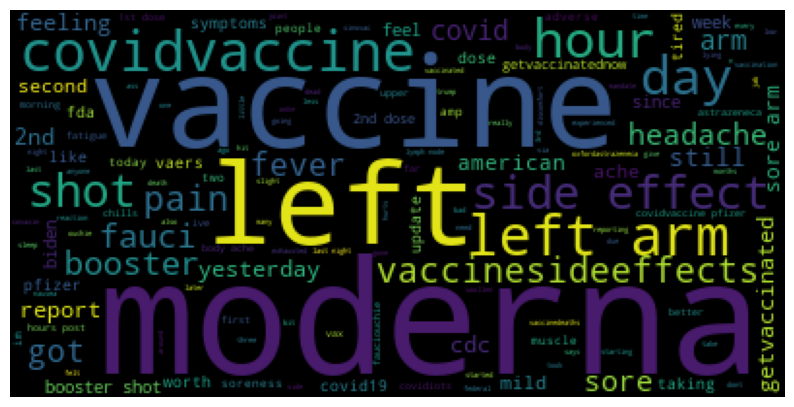

In [117]:
unkNeg = Counter(" ".join(negative_new['tweet_text']).split()).most_common(30)

plt.figure(figsize=(10,10))
wrd = WordCloud(stopwords=cachedStopWords)
wrd.generate(" ".join(negative_new.tweet_text))
plt.imshow(wrd)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

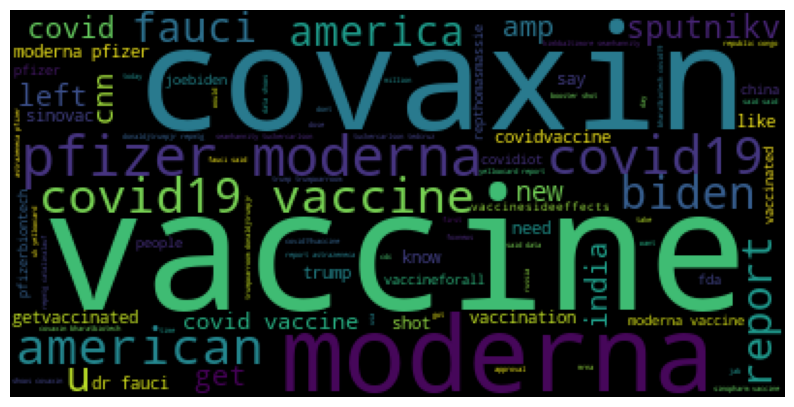

In [118]:
unkNeu = Counter(" ".join(neutral_new['tweet_text']).split()).most_common(30)

plt.figure(figsize=(10,10))
wrd = WordCloud(stopwords=cachedStopWords)
wrd.generate(" ".join(neutral_new.tweet_text))
plt.imshow(wrd)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

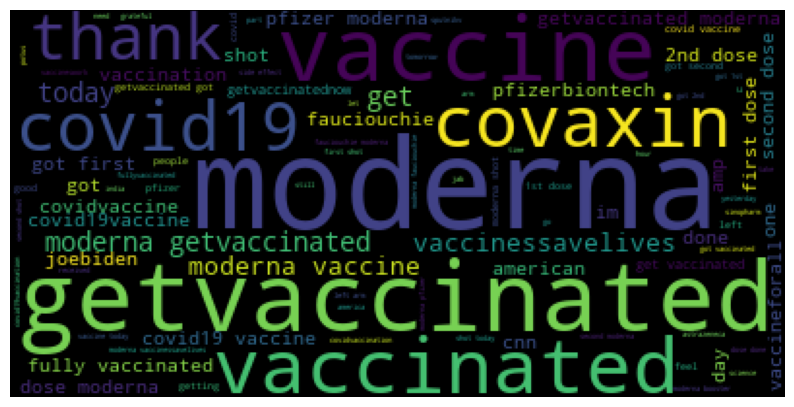

In [119]:
unkPos = Counter(" ".join(positive_new['tweet_text']).split()).most_common(30)

plt.figure(figsize=(10,10))
wrd = WordCloud(stopwords=cachedStopWords)
wrd.generate(" ".join(positive_new.tweet_text))
plt.imshow(wrd)
plt.axis('off')

### Visualize the sentiments with the biased labels still included

['trump', 'biden', 'fauci', 'left', 'right', 'getvaccinated', 'america', 'joe', 'cnn', 'rep', 'dem']
[-5, -8, -21, -53, -2, -18, -11, -2, -2, -21, -3]
[55, 288, 320, 142, 47, 1153, 192, 232, 106, 157, 121]


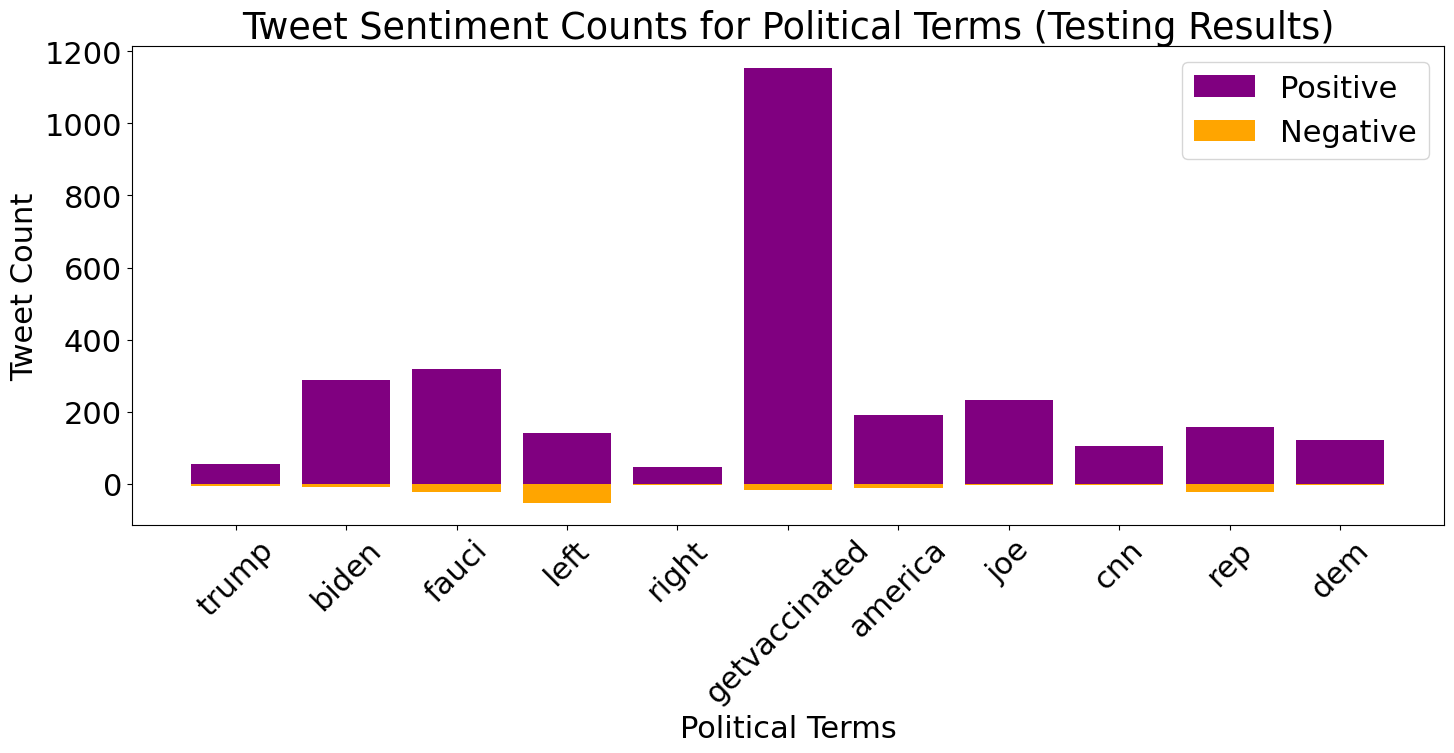

In [120]:
# politicalTerms = ['trump', 'conservative', 'maga', 'fakenews', 'GOP', 'biden', 'biden', 'harris', 'haris',
#          'fauci', 'democrat', 'left', 'vaccinessavelives', 'followthescience',
#          'getvaccinated', 'vaccineforall', 'covidiots', 'sidesffects', 'america', 'joe', 'kamila', 'foxnews',
#          'blm', 'karen', 'cnn', 'police', 'rep', 'dem', 'right']

"""This is for graphing inside of the final paper 
Uncomment the above if you want to see a bigger graph including all of the term and comment out the one below"""

politicalTerms= ['trump',  'biden', 
         'fauci', 'left', 'right', 'getvaccinated',
          'america', 'joe', 'cnn', 'rep', 'dem']
negativeTerms = []
positiveTerms = []

for pol in politicalTerms:
    tempFramePol = only_text[only_text['tweet_text'].str.contains(pol)]
    countPol = tempFramePol['tweet_text'].count()
    goodPol  = tempFramePol[tempFramePol['Sentiments'] == 3]
    countGPol = goodPol['tweet_text'].count()
    badPol  = tempFramePol[tempFramePol["Sentiments"] == 1]
    countBPol = badPol['tweet_text'].count() * -1
    
    negativeTerms.append(countBPol)
    positiveTerms.append(countGPol)

print(politicalTerms)
print(negativeTerms)
print(positiveTerms)

plt.figure(figsize=(15, 8))
plt.bar(politicalTerms, positiveTerms, color='purple', label='Positive')
plt.bar(politicalTerms, negativeTerms, color='orange', label='Negative')
plt.xlabel('Political Terms')
plt.ylabel('Tweet Count')
plt.title('Tweet Sentiment Counts for Political Terms (Testing Results)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.rcParams.update({'font.size': 22})

### Clean out all of the political markers

In [121]:
no_politic_text = only_text.copy()
no_politic_text['tweets_no'] = only_text["tweet_text"].copy()



politicalTerms = ['trump', 'conservative', 'maga', 'fakenews', 'GOP', 'biden', 'biden', 'harris', 'haris',
         'fauci', 'democrat', 'left', 'vaccinessavelives', 'followthescience',
         'getvaccinated', 'vaccineforall', 'covidiots', 'sidesffects', 'america', 'joe', 'kamila', 'foxnews',
         'blm', 'karen', 'cnn', 'police', 'rep', 'dem', 'right', 'donald', 'mike', 'pence', 'usa', 'president']



for term in politicalTerms:
    no_politic_text['tweets_no'] = no_politic_text['tweets_no'].str.replace(term, '')
    
print(no_politic_text['tweet_text'][20:30].values)
print(no_politic_text['tweets_no'][20:30].values)

['kind america leave behind trump donaldtrump joebiden newyork washington whitehouse'
 'chesleydohl audiemurphy45 cspan trump claiming pfizerbiontech vaccine one administrati'
 'great day country amp world realdonaldtrump one day closer leaving whitehouse first'
 'realdonaldtrump varneyco pfizer funded operation warp speed would never supported mus'
 'tedcruz know trumpkins like informed goes 1 pfizerbiontech vaccine developed in'
 'joebiden kamalaharris thanks bringing fresh air positivity gods hand pushing us forw'
 'interesting watch cnns newday live coverage loading pfizerbiontechs vaccine pfizer plant at'
 'vaccines acomin  covid19 coronavirus vaccine pfizerbiontech cnn msnbc'
 'us president donald trump announced vaccine free americans thanked scienti'
 'pmjones14 pfizerbiontech created vaccine trump recommended bleach injections ']
['kind  leave behind    newyork washington whitehouse'
 'chesleydohl audiemurphy45 cspan  claiming pfizerbiontech vaccine one administrati'
 'great d

In [122]:
clean_test = word_tokenizers.texts_to_sequences(no_politic_text['tweets_no'])

padding_size = 125

clean_test = pad_sequences(clean_test, padding='post', maxlen=padding_size)

predictions = snn_model.predict(clean_test)
predictions = np.argmax(predictions, axis=1) + 1

no_politic_text['Clean_Sentiments'] = predictions

print(no_politic_text.head(10))

263/263 [==============================] - 8s 31ms/step
                                           tweet_text  Sentiments   
7   many bright days 2020 best 1 bidenharris winni...           3  \
15  trump announces vaccine rollout less 24 hours ...           2   
19  trump administration failed deliver vaccine pr...           2   
22  trump announces vaccine rollout less 24 hours ...           2   
27  avgerinosmoscow pfizerbiontech fda approval ap...           2   
29  vaccine trumpvaccine astrazeneca pfizerbiontec...           2   
43  trump announces vaccine rollout less 24 hours ...           2   
46  realdonaldtrump dairy dose dumbsville dontheco...           2   
51  ive never excited get vaccine covidvaccine pfi...           3   
66  icu nurse sandra lindsay said proud becoming o...           3   

                                            tweets_no  Clean_Sentiments  
7       many b days 2020 best 1  winning election2020                 3  
15   announces vaccine rollout less 

### Display the new graphing results from fitting cleaned dataset

['trump', 'biden', 'fauci', 'left', 'right', 'getvaccinated', 'america', 'joe', 'cnn', 'rep', 'dem']
[-5, -11, -10, -57, -2, -22, -15, -2, -5, -16, -3]
[69, 231, 318, 144, 32, 951, 165, 165, 73, 179, 105]


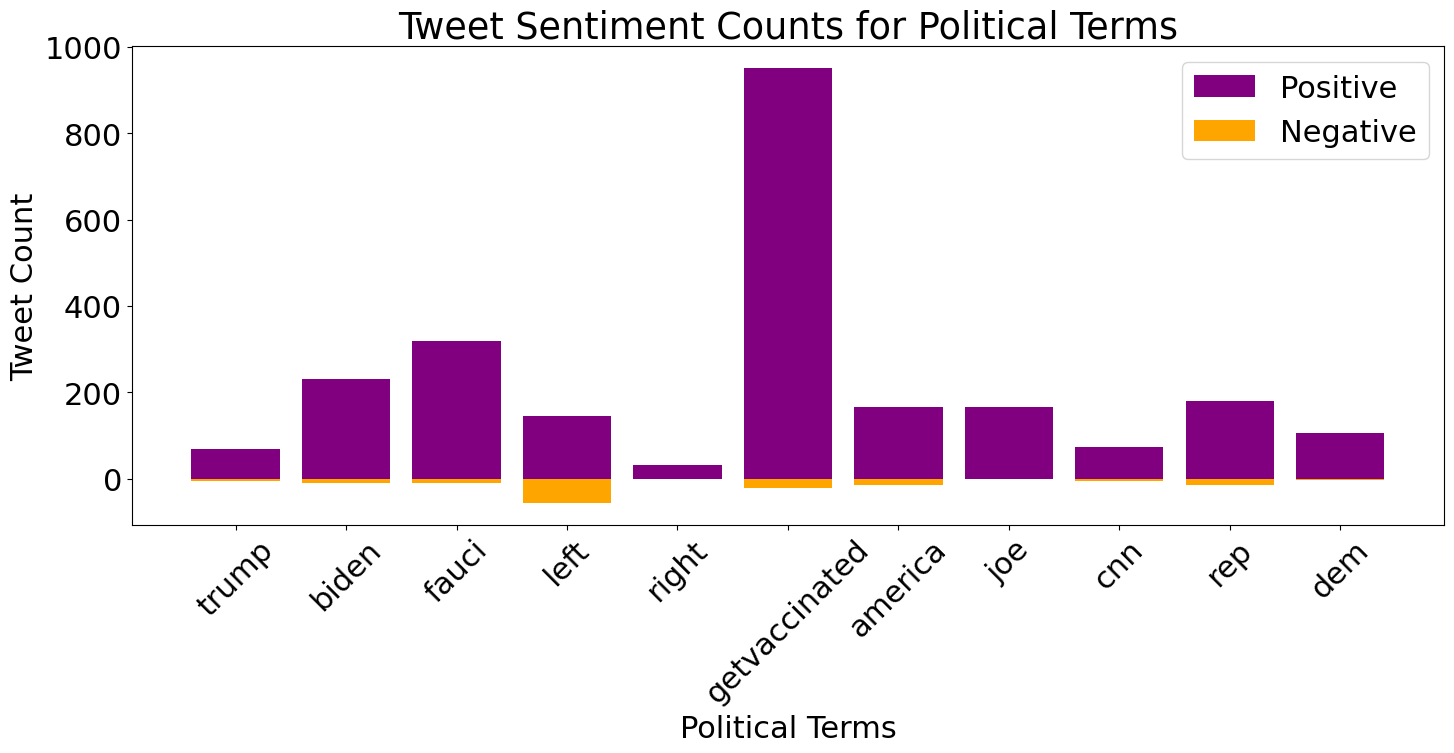

In [123]:


# politicalTermsWithout = ['trump', 'conservative', 'maga', 'fakenews', 'GOP', 'biden', 'biden', 'harris', 'haris',
        #  'fauci', 'democrat', 'left', 'vaccinessavelives', 'followthescience',
        #  'getvaccinated', 'vaccineforall', 'covidiots', 'sidesffects', 'america', 'joe', 'kamila', 'foxnews',
        #  'blm', 'karen', 'cnn', 'police', 'rep', 'dem', 'right']


politicalTermsWithoutGraphing = ['trump',  'biden', 
         'fauci', 'left', 'right', 'getvaccinated',
           'america', 'joe', 'cnn', 'rep', 'dem']

negativeTermsWithout = []
positiveTermsWithout = []

for pol in politicalTermsWithoutGraphing:
    tempFramePol = no_politic_text[no_politic_text['tweet_text'].str.contains(pol)]
    countPol = tempFramePol['tweet_text'].count()
    goodPol  = tempFramePol[tempFramePol['Clean_Sentiments'] == 3]
    countGPol = goodPol['tweet_text'].count()
    badPol  = tempFramePol[tempFramePol["Clean_Sentiments"] == 1]
    countBPol = badPol['tweet_text'].count() * -1
    
    negativeTermsWithout.append(countBPol)
    positiveTermsWithout.append(countGPol)

# print(politicalTermsWithout)
print(politicalTermsWithoutGraphing)
print(negativeTermsWithout)
print(positiveTermsWithout)

plt.figure(figsize=(15, 8))
# plt.bar(politicalTermsWithout, positiveTermsWithout, color='purple', label='Positive')
# plt.bar(politicalTermsWithout, negativeTermsWithout, color='orange', label='Negative')
plt.bar(politicalTermsWithoutGraphing, positiveTermsWithout, color='purple', label='Positive')
plt.bar(politicalTermsWithoutGraphing, negativeTermsWithout, color='orange', label='Negative')
plt.xlabel('Political Terms')
plt.ylabel('Tweet Count')
plt.title('Tweet Sentiment Counts for Political Terms')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [124]:
no_politic_text

,tweet_text,Sentiments,tweets_no,Clean_Sentiments
7,many bright days 2020 best 1 bidenharris winni...,3,many b days 2020 best 1 winning election2020,3
15,trump announces vaccine rollout less 24 hours ...,2,announces vaccine rollout less 24 hours first...,2
19,trump administration failed deliver vaccine pr...,2,administration failed deliver vaccine promise...,2
22,trump announces vaccine rollout less 24 hours ...,2,announces vaccine rollout less 24 hours first...,2
27,avgerinosmoscow pfizerbiontech fda approval ap...,2,avgerinosmoscow pfizerbiontech fda approval ap...,2
...,...,...,...,...
227778,platinumjab cowin app used many african south ...,2,platinumjab cowin app used many african south ...,2
227931,anyone facing sudden changes body weeks vaccin...,2,anyone facing sudden changes body weeks vaccin...,2
228077,mdamericas evident due geo politics lab wars a...,2,mds evident due geo politics lab wars approve ...,2
228079,vaccine discrimination latin americans immuniz...,2,vaccine discrimination latin ns immunized sput...,2


### Calculate the changes in the sentiment classification > Create the wholistic bias percentage

In [125]:
no_politic_text['biased'] = (no_politic_text['Sentiments'] == no_politic_text['Clean_Sentiments']).astype(int)
no_politic_text

,tweet_text,Sentiments,tweets_no,Clean_Sentiments,biased
7,many bright days 2020 best 1 bidenharris winni...,3,many b days 2020 best 1 winning election2020,3,1
15,trump announces vaccine rollout less 24 hours ...,2,announces vaccine rollout less 24 hours first...,2,1
19,trump administration failed deliver vaccine pr...,2,administration failed deliver vaccine promise...,2,1
22,trump announces vaccine rollout less 24 hours ...,2,announces vaccine rollout less 24 hours first...,2,1
27,avgerinosmoscow pfizerbiontech fda approval ap...,2,avgerinosmoscow pfizerbiontech fda approval ap...,2,1
...,...,...,...,...,...
227778,platinumjab cowin app used many african south ...,2,platinumjab cowin app used many african south ...,2,1
227931,anyone facing sudden changes body weeks vaccin...,2,anyone facing sudden changes body weeks vaccin...,2,1
228077,mdamericas evident due geo politics lab wars a...,2,mds evident due geo politics lab wars approve ...,2,1
228079,vaccine discrimination latin americans immuniz...,2,vaccine discrimination latin ns immunized sput...,2,1


In [130]:
biased = no_politic_text[no_politic_text["biased"] == 0]
biased = biased["biased"].count()

total = no_politic_text['biased'].count()

print((biased/total)*100)

8.627264061010486


### Above is final Bias Percentage 

## RETRAIN MODEL ON NON POLITICAL DATA (UNFINISHED)

In [127]:
no_politic_Train = sentiment_df.copy()
no_politic_Train['tweets_no'] = sentiment_df["tweet_text"].copy()



politicalTerms = ['trump', 'conservative', 'maga', 'fakenews', 'GOP', 'biden', 'biden', 'harris', 'haris',
         'fauci', 'democrat', 'left', 'vaccinessavelives', 'followthescience',
         'getvaccinated', 'vaccineforall', 'covidiots', 'sidesffects', 'america', 'joe', 'kamila', 'foxnews',
         'blm', 'karen', 'cnn', 'police', 'rep', 'dem', 'right', 'donald', 'mike', 'pence', 'usa', 'president']



for term in politicalTerms:
    no_politic_Train['tweets_no'] = no_politic_Train['tweets_no'].str.replace(term, '')


no_politic_text.head(10)


,tweet_text,Sentiments,tweets_no,Clean_Sentiments,biased
7,many bright days 2020 best 1 bidenharris winni...,3,many b days 2020 best 1 winning election2020,3,1
15,trump announces vaccine rollout less 24 hours ...,2,announces vaccine rollout less 24 hours first...,2,1
19,trump administration failed deliver vaccine pr...,2,administration failed deliver vaccine promise...,2,1
22,trump announces vaccine rollout less 24 hours ...,2,announces vaccine rollout less 24 hours first...,2,1
27,avgerinosmoscow pfizerbiontech fda approval ap...,2,avgerinosmoscow pfizerbiontech fda approval ap...,2,1
29,vaccine trumpvaccine astrazeneca pfizerbiontec...,2,vaccine vaccine astrazeneca pfizerbiontech pfi...,2,1
43,trump announces vaccine rollout less 24 hours ...,2,announces vaccine rollout less 24 hours first...,2,1
46,realdonaldtrump dairy dose dumbsville dontheco...,2,real dairy dose dumbsville donthecon grifterin...,2,1
51,ive never excited get vaccine covidvaccine pfi...,3,ive never excited get vaccine covidvaccine pfi...,3,1
66,icu nurse sandra lindsay said proud becoming o...,3,icu nurse sandra lindsay said proud becoming o...,3,1


In [128]:
X = []
X = no_politic_Train['tweets_no'].values

y = no_politic_Train['label'].values

In [129]:

#using Tokenizers to make the dimentionality smaller for our given problem. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

word_tokenizers = Tokenizer()

#Important to use this in the future for the unlabeled data set that I will be making 
word_tokenizers.fit_on_texts(X_train)


X_train = word_tokenizers.texts_to_sequences(X_train)
X_test = word_tokenizers.texts_to_sequences(X_test)

total_len = len(word_tokenizers.word_index) + 1
total_len



padding_size = 125

X_train = pad_sequences(X_train, padding='post', maxlen=padding_size)
X_test = pad_sequences(X_test, padding='post', maxlen=padding_size)
from keras.utils import to_categorical
from keras.utils import plot_model
# Assuming y_train and y_test are your label arrays with values 0, 1, or 2
y_train_encoded = to_categorical(y_train - 1, num_classes=3)
y_test_encoded = to_categorical(y_test - 1, num_classes=3)

embedding_feats = 200
snn_model = Sequential()
embbeding_layer = Embedding(total_len, embedding_feats, input_length=padding_size)
snn_model.add(embbeding_layer)
snn_model.add(Bidirectional(LSTM(50, activation='tanh', dropout=.2, recurrent_dropout=.2)))
snn_model.add(Dense(10, activation='tanh'))
snn_model.add(Dense(3, activation='softmax'))
snn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(snn_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 125, 200)          3404200   
                                                                 
 bidirectional_4 (Bidirecti  (None, 100)               100400    
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 10)                1010      
                                                                 
 dense_9 (Dense)             (None, 3)                 33        
                                                                 
Total params: 3505643 (13.37 MB)
Trainable params: 3505643 (13.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Wanted to add a similar test to what was above but ran out of time...